Load Dataset

In [66]:
#Load files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

df = pd.read_excel("Prices.xlsx", engine = "openpyxl") #Read file
df = df.dropna()  #Clean dataset
df.head()

,Date,NPN,SBK,ANG,SHP,INL,SOL,IMP,GRT,APN,BVT
0,2000-01-04,2.858353e+07,2812.4650,14089.4037,900,3123.6440,4950,1596.6423,402.9484,402.9484,1596.6423
1,2000-01-05,2.800217e+07,2823.7149,13995.7864,900,3125.9493,4905,1567.2234,402.9484,402.9484,1567.2234
2,2000-01-06,2.761460e+07,2778.7154,14042.5950,870,3098.2860,4980,1567.2234,393.1204,393.1204,1567.2234
3,2000-01-07,2.892266e+07,2834.9647,14697.9161,870,3112.1176,5190,1580.5956,417.6904,417.6904,1580.5956
4,2000-01-10,3.076363e+07,3149.9608,15212.8113,870,3197.4127,5300,1604.6656,437.3464,437.3464,1604.6656


### Perform EDA

                NPN      SBK      ANG      SHP      INL      SOL      IMP  \
count       6619.00  6619.00  6619.00  6619.00  6619.00  6619.00  6619.00   
mean   530220883.46 11526.28 25585.18 11534.96  4656.32 27519.37  9647.73   
min            0.00     0.00     0.00   500.00   881.77  2188.00  1068.25   
25%     33445152.15  8066.71 17124.00  2350.00  2725.98 13035.50  2533.98   
50%    171501178.56 11272.00 25929.00 12566.00  3776.61 27840.00  5557.40   
75%   1071590000.00 15300.00 31200.50 18082.50  5559.45 38665.00 17841.00   
max   1982852450.00 25042.00 86320.00 31452.00 14224.00 64510.00 29488.00   
std    607402133.53  5348.82 10718.40  8778.24  2917.78 14399.31  8587.47   

           GRT      APN      BVT  
count  6619.00  6619.00  6619.00  
mean  12881.71 12881.71  9647.73  
min     393.12   393.12  1068.25  
25%    3164.62  3164.62  2533.98  
50%   10324.00 10324.00  5557.40  
75%   20101.00 20101.00 17841.00  
max   44300.00 44300.00 29488.00  
std   11075.40 11075.40  8

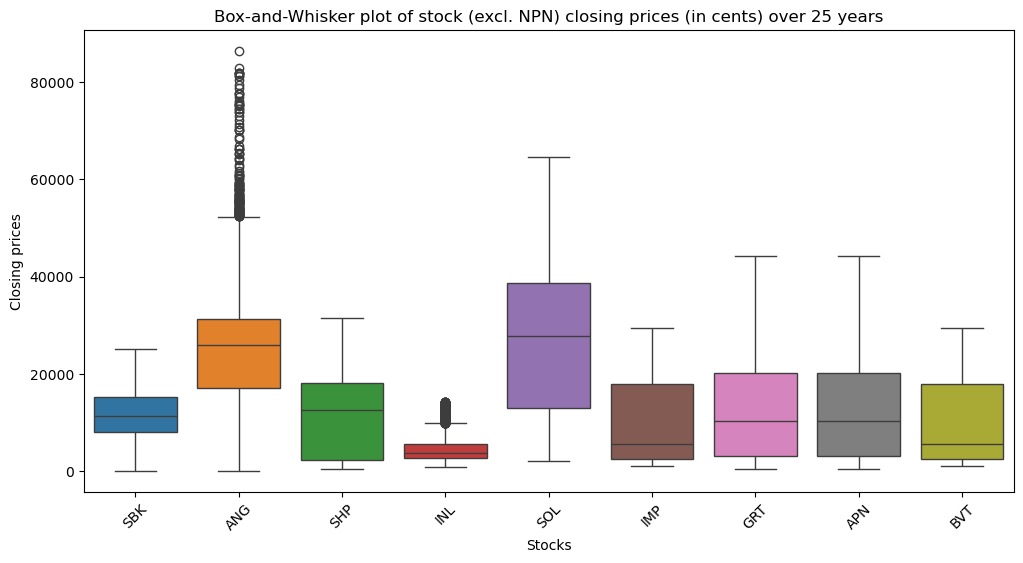

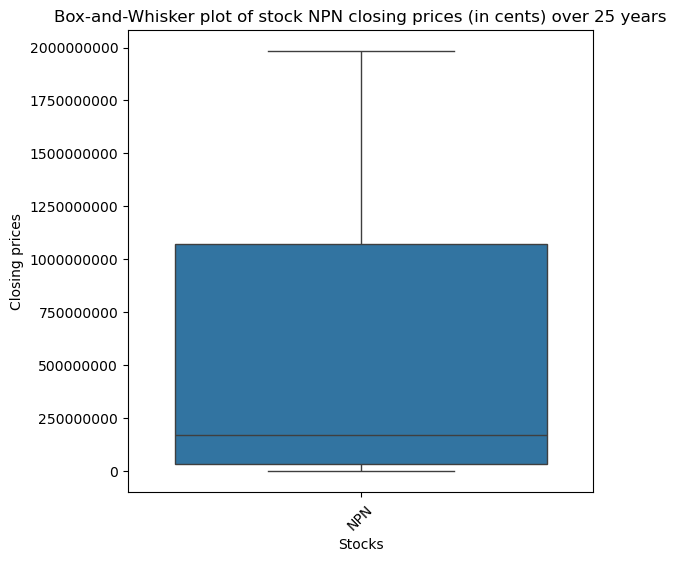

In [121]:
#5-number summary, and
#Box-and-whisker plots

pd.set_option('display.float_format', '{:.2f}'.format)  # Limits to 2 decimal places
print(df.describe().iloc[:, 1:]) #excludes the first column, i.e. date

plt.figure(figsize = (12, 6)) #Plot size: 12 inches wide and 6 inches tall
sns.boxplot(data = df.iloc[:, 2:]) #Plots the stocks excluding NPN
plt.xlabel("Stocks")
plt.ylabel("Closing prices")
plt.title("Box-and-Whisker plot of stock (excl. NPN) closing prices (in cents) over 25 years")
plt.xticks(rotation = 45)
plt.show()

#For Naspers
plt.figure(figsize = (6, 6))
sns.boxplot(data = df.iloc[:, :2]) #Plots the stocks excluding NPN
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
plt.xlabel("Stocks")
plt.ylabel("Closing prices")
plt.title("Box-and-Whisker plot of stock NPN closing prices (in cents) over 25 years")
plt.xticks(rotation = 45)
plt.show()

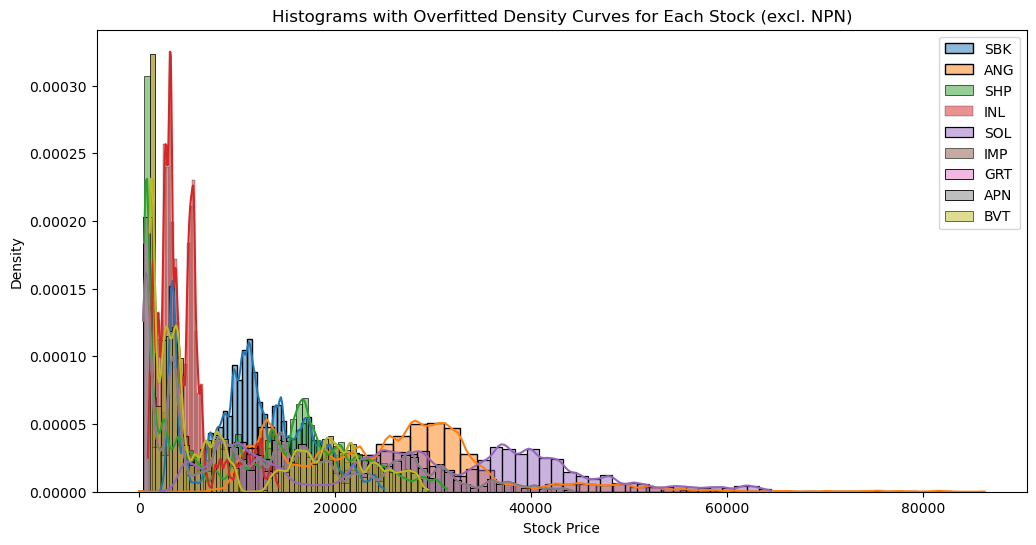

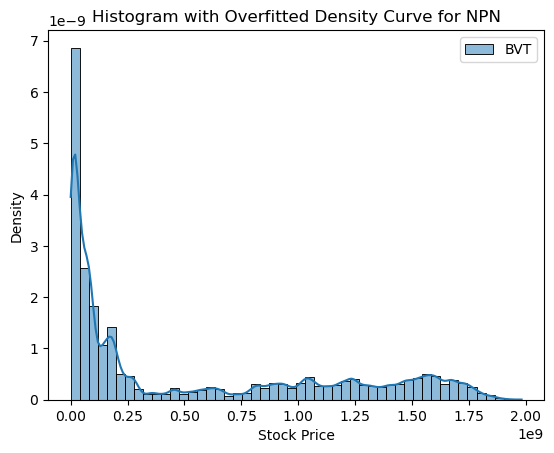

In [106]:
#Histogram with density curves
plt.figure(figsize=(12, 6))

# Loop through each stock column and plot its histogram with Kernel Desnity Estimation (KDE)
for col in df.columns[2:]:  # Assuming first column is Date and was removed
    sns.histplot(df[col], kde=True, bins=50, stat="density", kde_kws={"bw_adjust": 0.2}, label=col)

plt.xlabel("Stock Price")
plt.ylabel("Density")
plt.title("Histograms with Overfitted Density Curves for Each Stock (excl. NPN)")
plt.legend()
plt.show()

#For Naspers
sns.histplot(df[df.columns[1:2]], kde=True, bins=50, stat="density", kde_kws={"bw_adjust": 0.2}, label=col)

plt.xlabel("Stock Price")
plt.ylabel("Density")
plt.title("Histogram with Overfitted Density Curve for NPN")
plt.legend()
plt.show()

<Axes: >

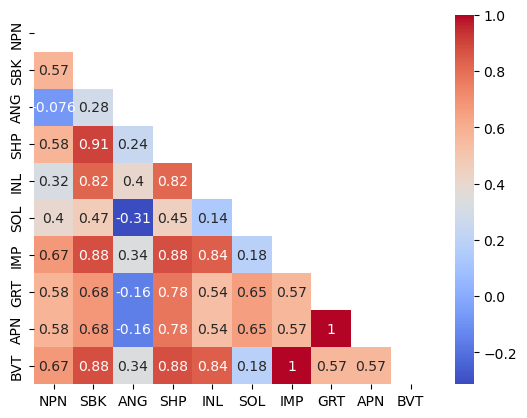

In [122]:
#Correlation Heatmap
dff = df.iloc[:, 1:] #omitts date column
sns.heatmap(dff.corr(), mask = np.triu(np.ones_like(dff.corr(), dtype = bool)), annot = True, cmap = "coolwarm")


#### Time Series EDA

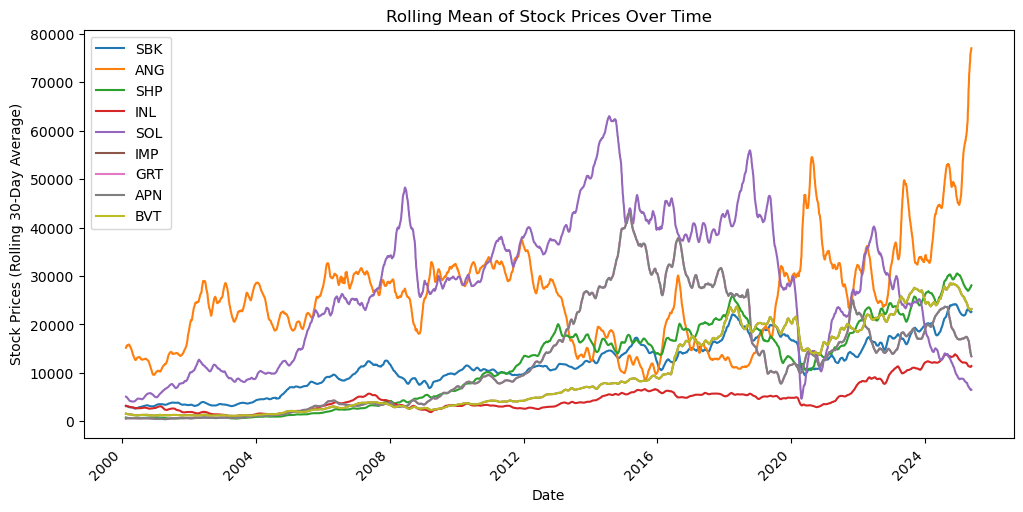

Text(0.5, 1.0, 'Rolling Mean of NPN Over Time')

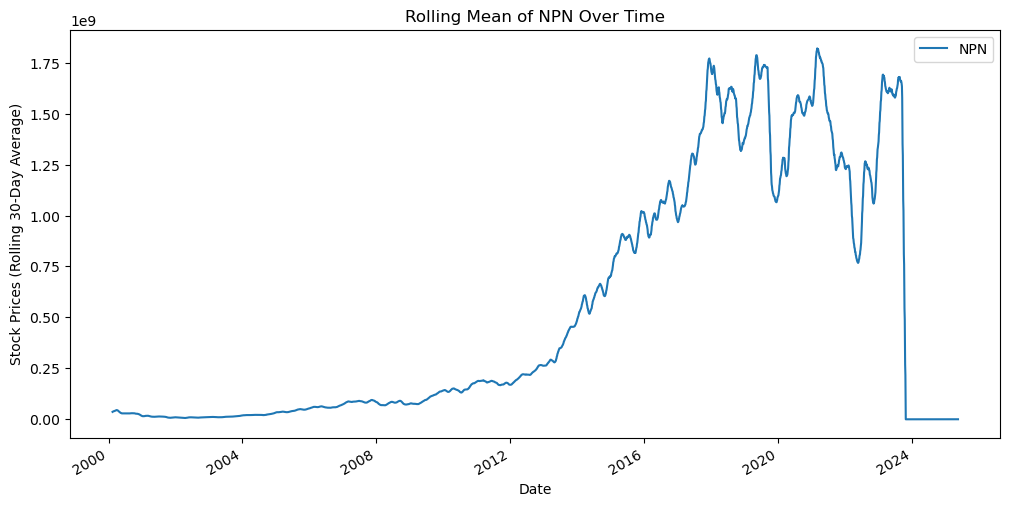

In [142]:
# Line trends
dff = df.copy() #Not corrupt data
dff.set_index(dff.columns[0], inplace=True)  # Set first column as index (Date)
dff.iloc[:, 1:].rolling(window=30).mean().plot(figsize=(12, 6))

plt.xlabel("Date")  # Label x-axis
plt.ylabel("Stock Prices (Rolling 30-Day Average)")
plt.title("Rolling Mean of Stock Prices Over Time")

plt.xticks(rotation=45)  # Improve readability of Date labels
plt.show()

dff.iloc[:, :-9].rolling(window=30).mean().plot(figsize=(12, 6))
plt.ylabel("Stock Prices (Rolling 30-Day Average)")
plt.title("Rolling Mean of NPN Over Time")

### Model Fitting

#### Stationarity

To confirm stationarity, the p-value should be less than the threshold (i.e. 1%, 5% or 10% significance level).

From below, clearly all are non-stationary.

In [177]:
#Dickey-Fuller Test
for col in df.columns[1:]: 
    result = adfuller(df[col])
    print(f" P-value for {col} : {result[1]}")

 P-value for NPN : 0.40844237983614373
 P-value for SBK : 0.7646722280565463
 P-value for ANG : 0.8047044718552934
 P-value for SHP : 0.9116593583628814
 P-value for INL : 0.9788200548039114
 P-value for SOL : 0.35441234990495996
 P-value for IMP : 0.9270239855225724
 P-value for GRT : 0.5439855469760666
 P-value for APN : 0.5439855469760666
 P-value for BVT : 0.9270239855225724


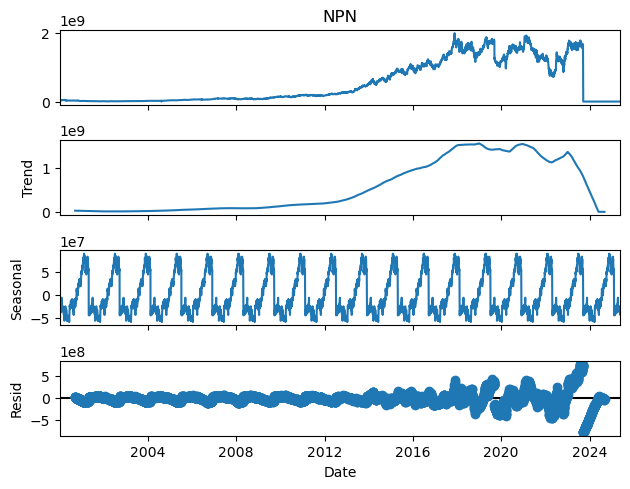

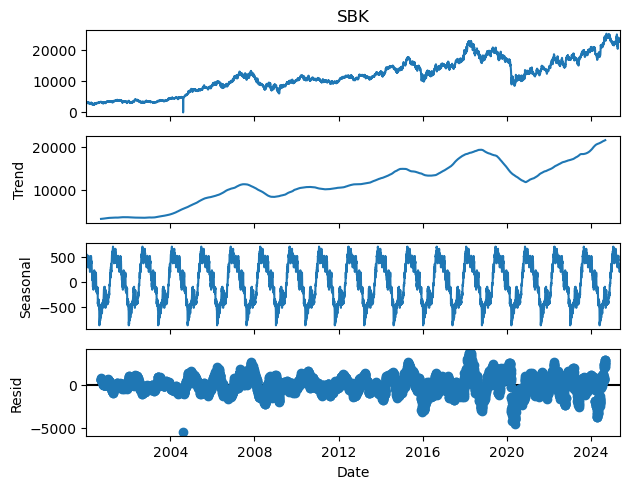

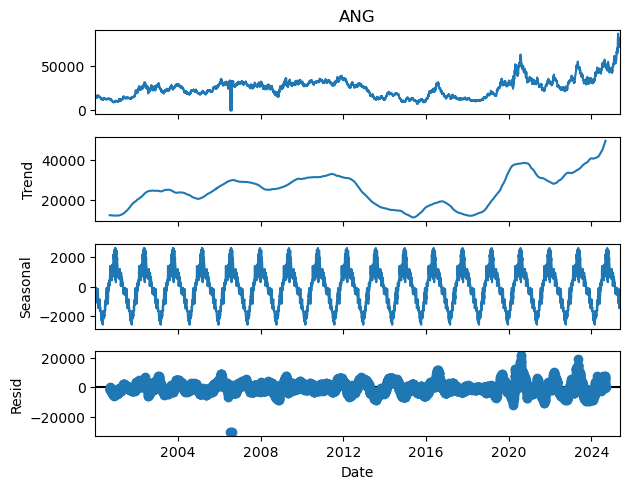

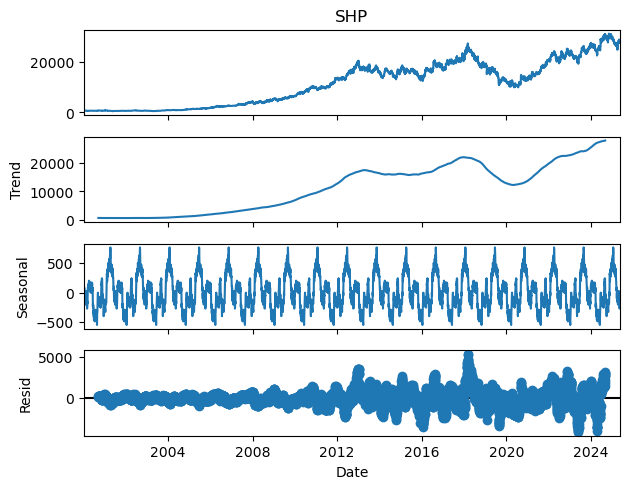

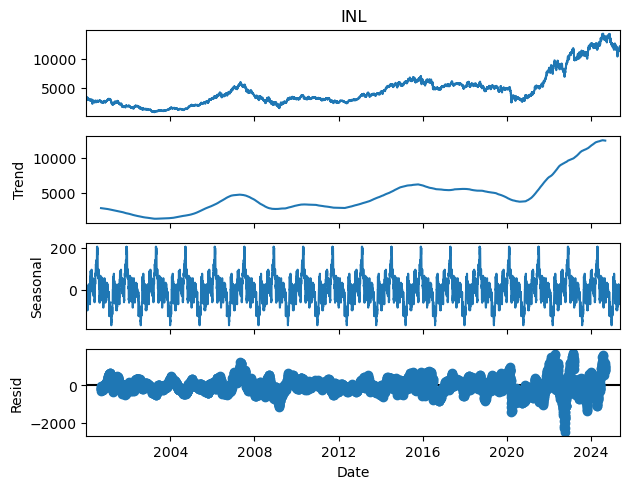

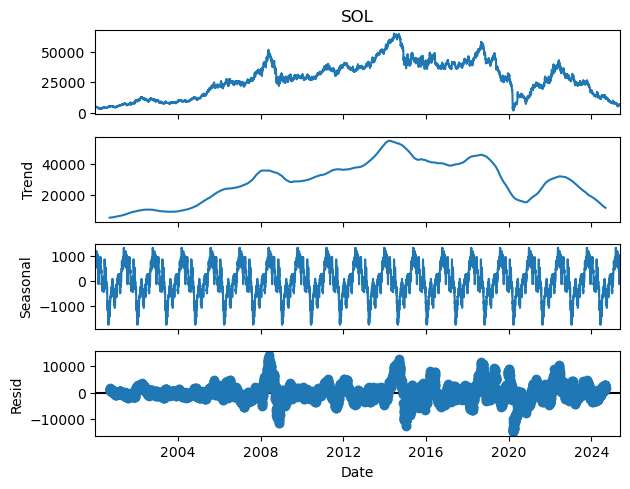

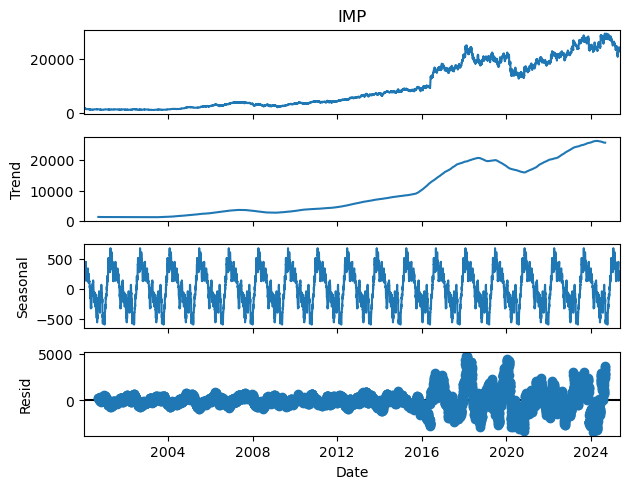

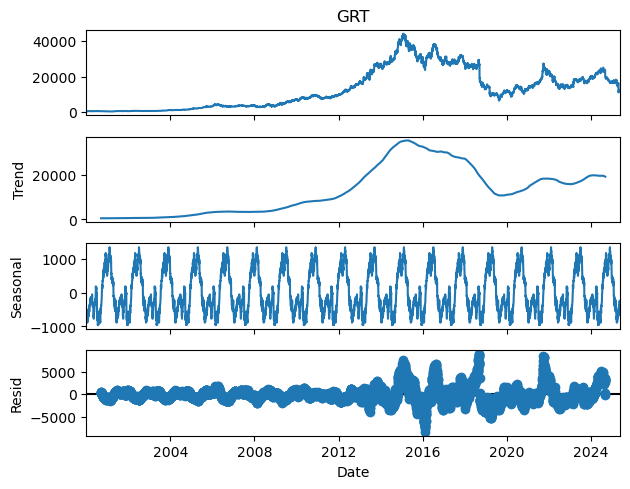

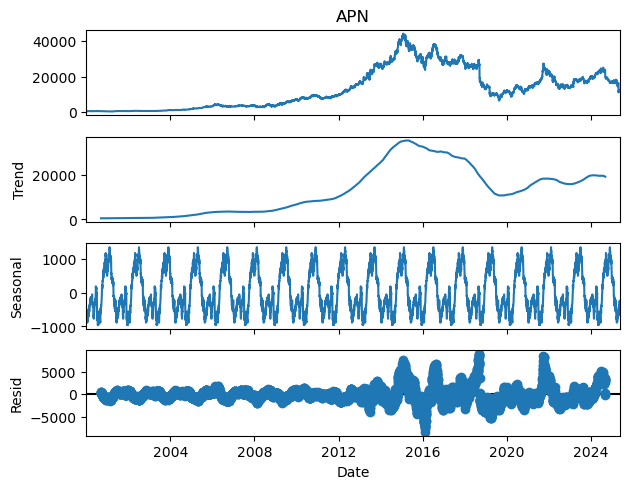

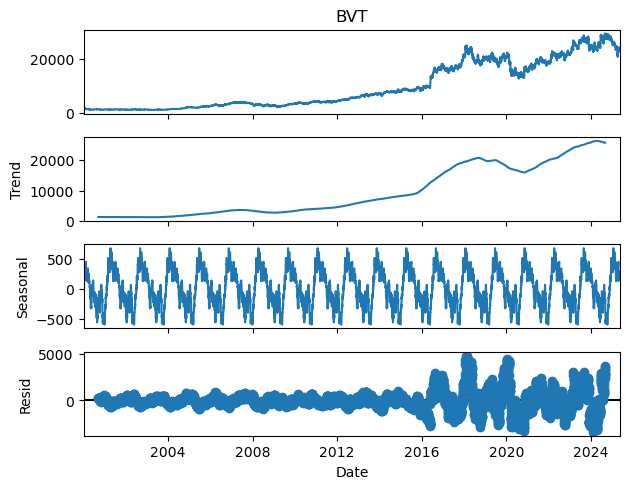

In [202]:
# Decomposition into trend, seasonality and residuals

for col in df.columns[1:]: 
    decomposition = seasonal_decompose(dff[col], period=365)
    decomposition.plot()
    plt.xlabel("Date")


Difference the non-stationary series to remove the trend and stabilize the mean. 

In [46]:
# 1st differenced Data
dff = []

dff = df.iloc[:, 1:].diff()
dff['Date'] = df['Date']

dff = dff[['Date'] + [col for col in dff.columns if col != 'Date']] #Rearrange columns
dff = dff.iloc[1:, :] #Delete first row

print(dff.head())

        Date           NPN       SBK       ANG   SHP      INL    SOL      IMP  \
1 2000-01-05 -5.813599e+05   11.2499  -93.6173   0.0   2.3053  -45.0 -29.4189   
2 2000-01-06 -3.875733e+05  -44.9995   46.8086 -30.0 -27.6633   75.0   0.0000   
3 2000-01-07  1.308060e+06   56.2493  655.3211   0.0  13.8316  210.0  13.3722   
4 2000-01-10  1.840973e+06  314.9961  514.8952   0.0  85.2951  110.0  24.0700   
5 2000-01-11  3.633500e+06  -39.3745 -514.8952   0.0  87.6003 -230.0 -32.0933   

        GRT       APN      BVT  
1    0.0000    0.0000 -29.4189  
2   -9.8280   -9.8280   0.0000  
3   24.5700   24.5700  13.3722  
4   19.6560   19.6560  24.0700  
5  108.1082  108.1082 -32.0933  


In [47]:
for col in dff.columns[1:]: 
    result = adfuller(dff[col])
    print(f" P-value for {col} : {result[1]}")

 P-value for NPN : 0.0
 P-value for SBK : 0.0
 P-value for ANG : 3.643524435672557e-28
 P-value for SHP : 2.103999467425889e-30
 P-value for INL : 1.0091338564024175e-27
 P-value for SOL : 0.0
 P-value for IMP : 0.0
 P-value for GRT : 0.0
 P-value for APN : 0.0
 P-value for BVT : 0.0


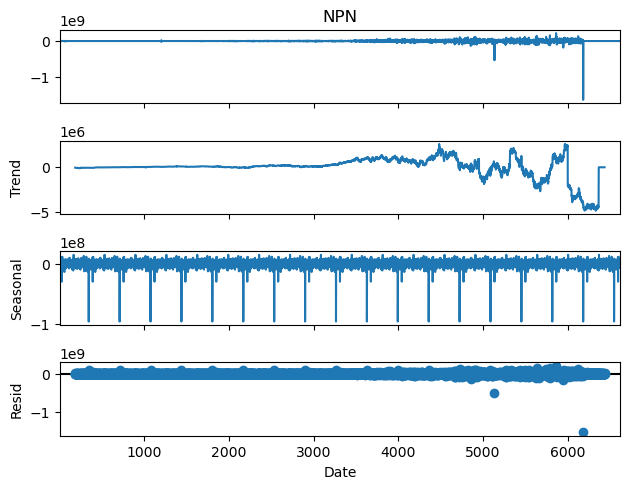

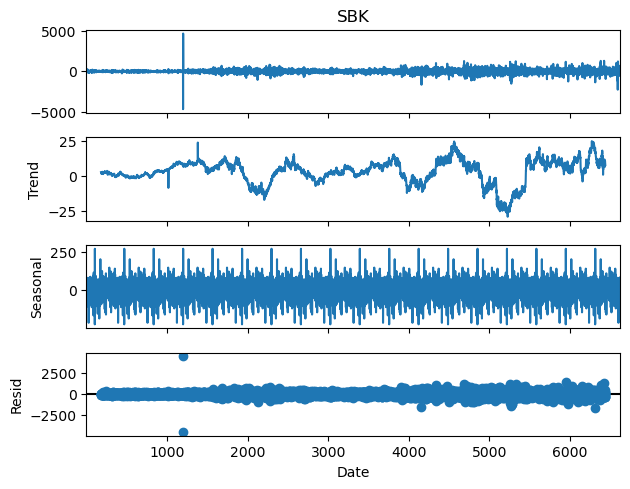

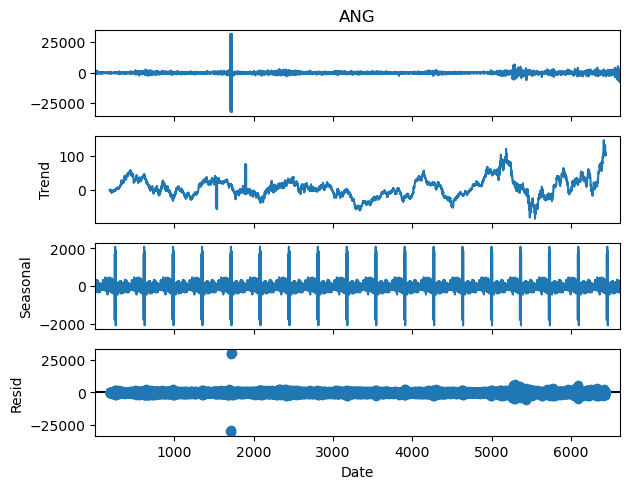

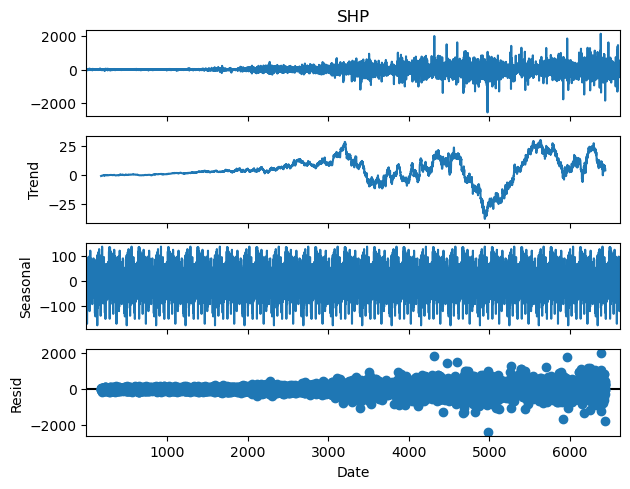

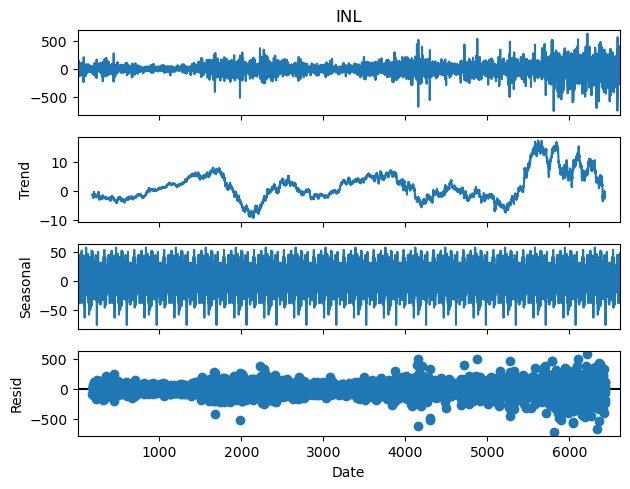

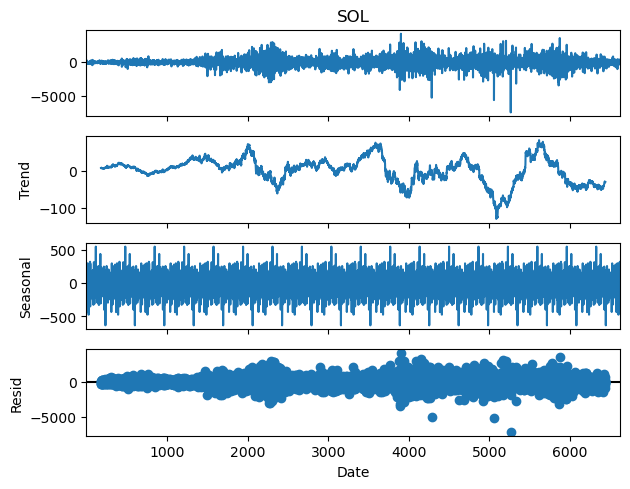

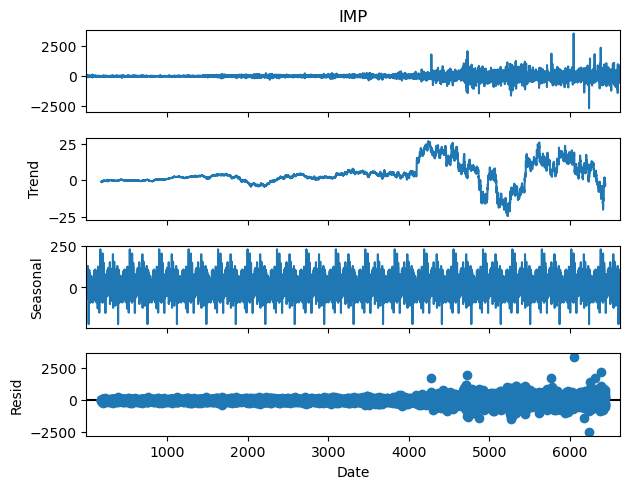

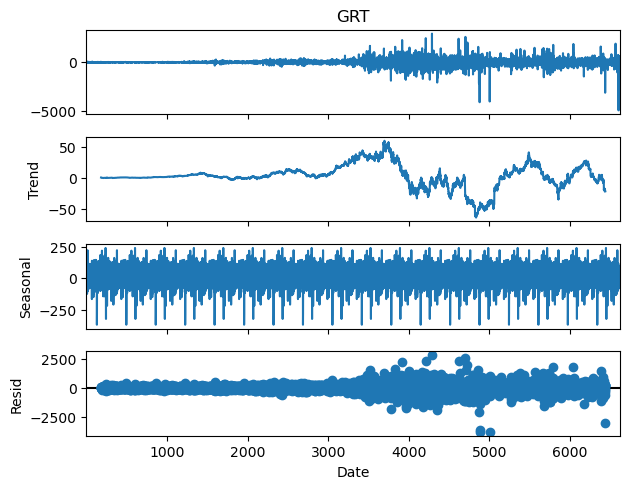

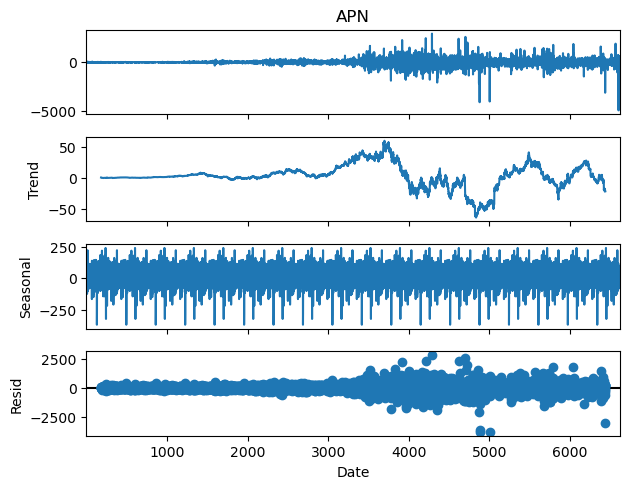

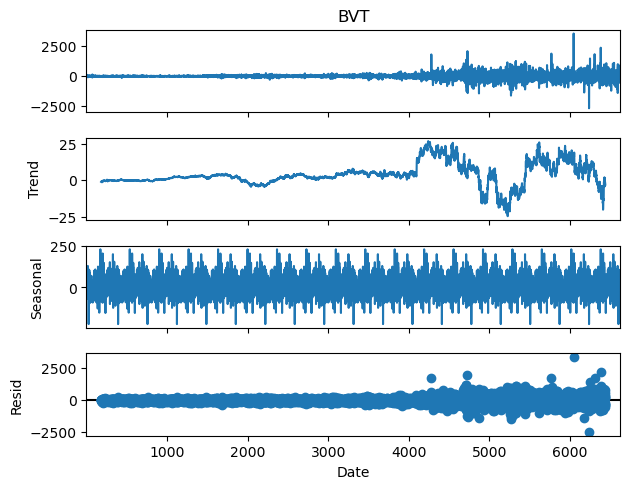

In [48]:
for col in dff.columns[1:]: 
    decomposition = seasonal_decompose(dff[col], period=365)
    decomposition.plot()
    plt.xlabel("Date")

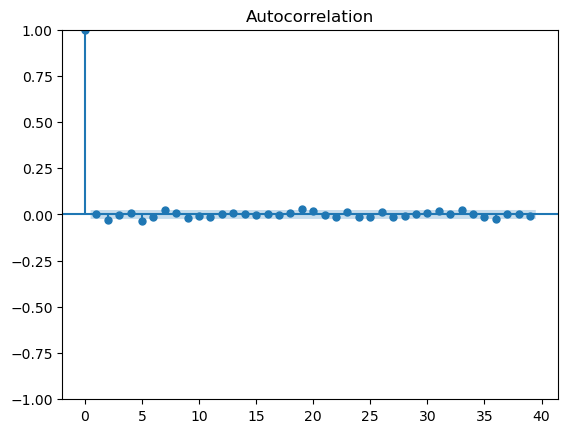

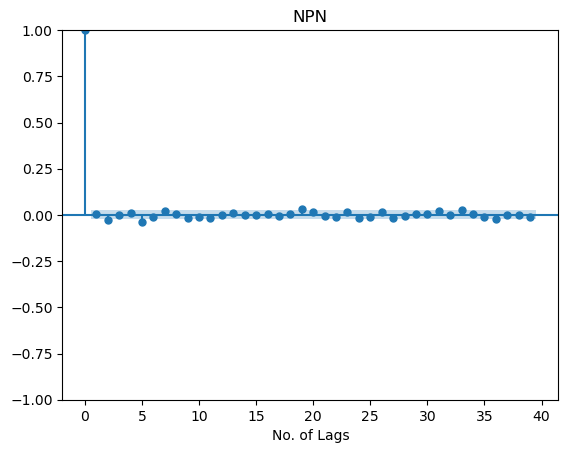

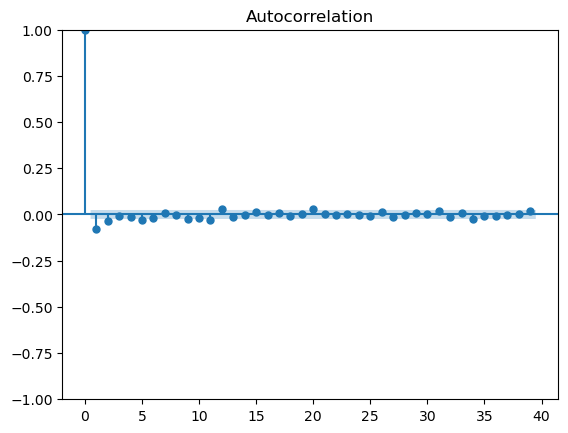

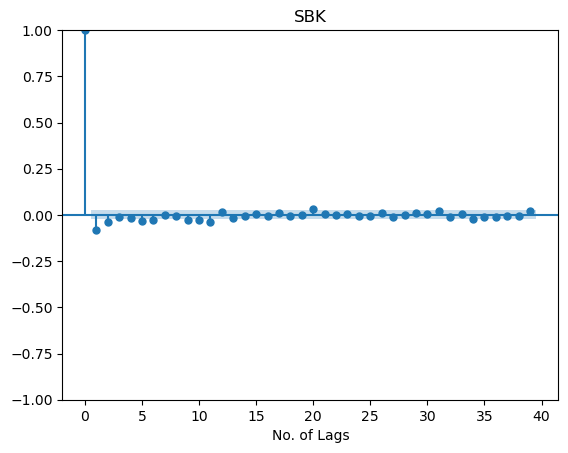

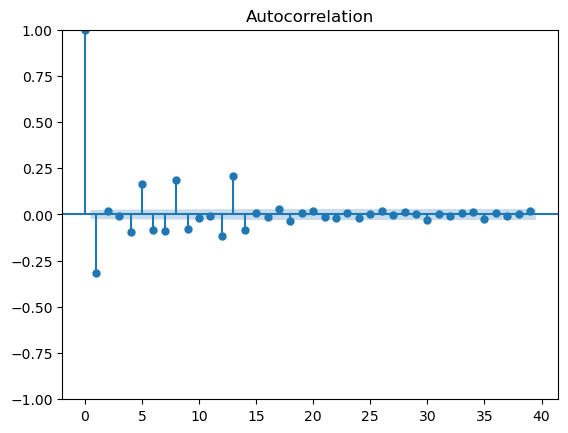

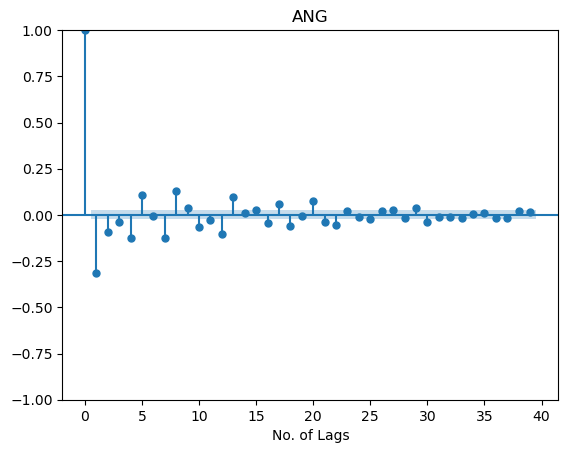

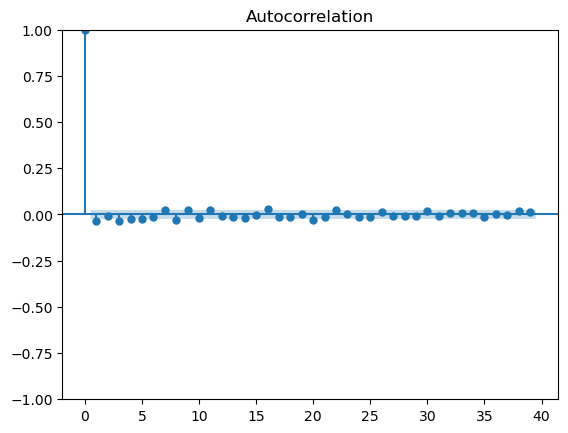

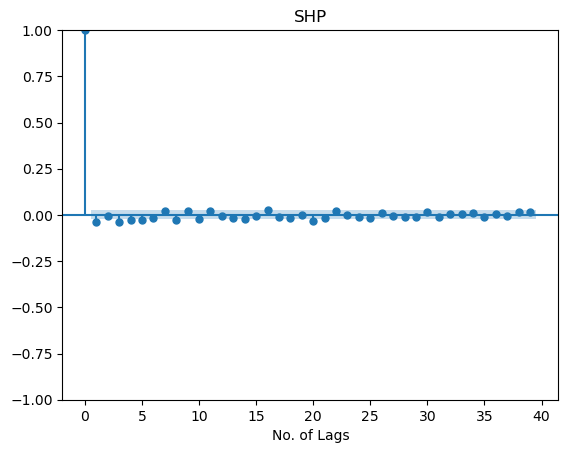

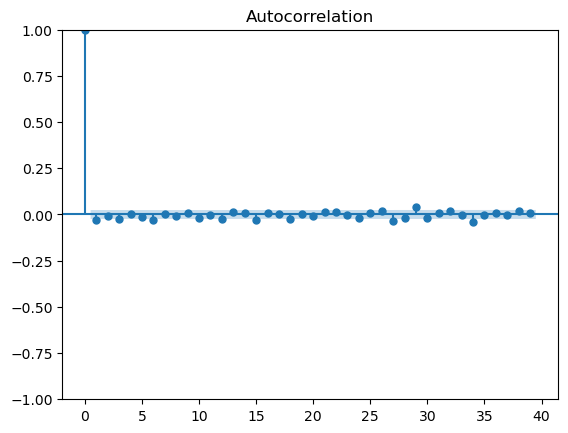

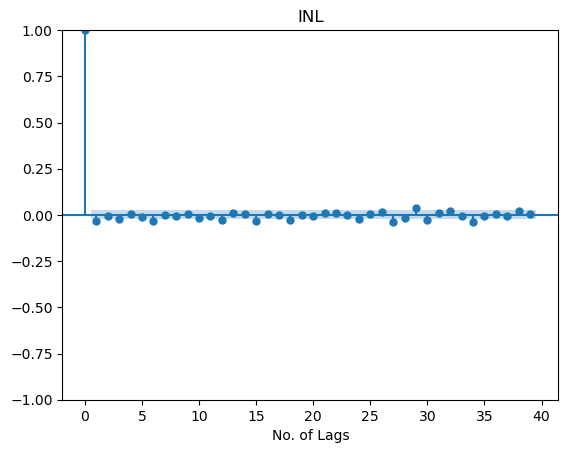

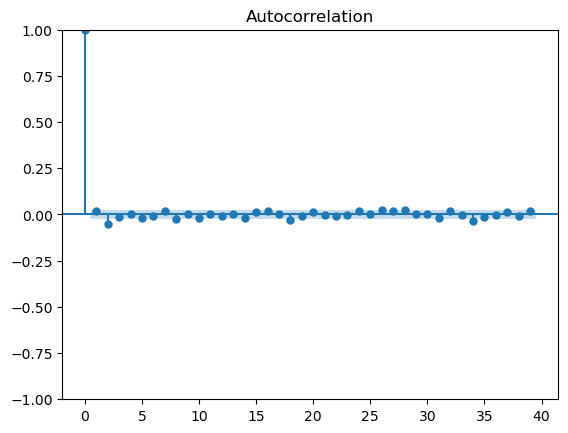

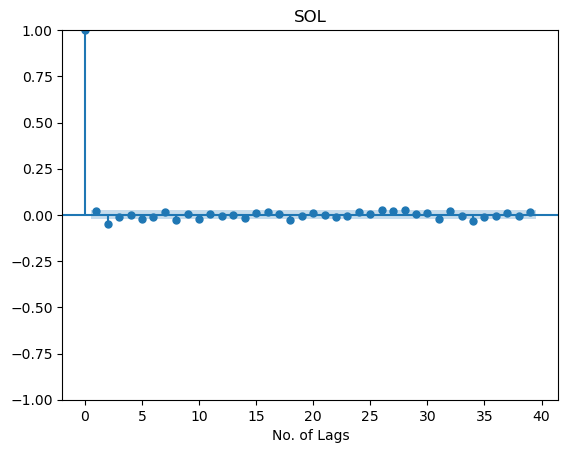

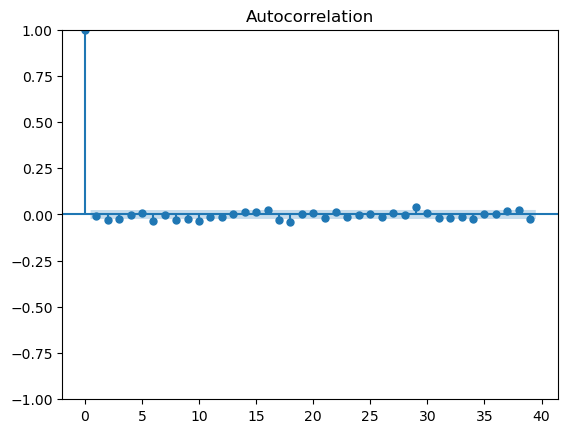

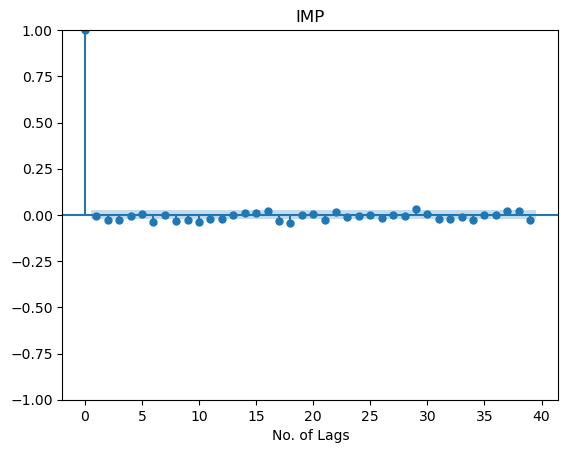

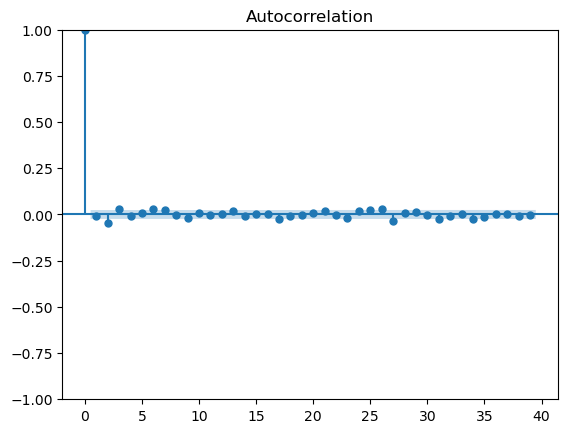

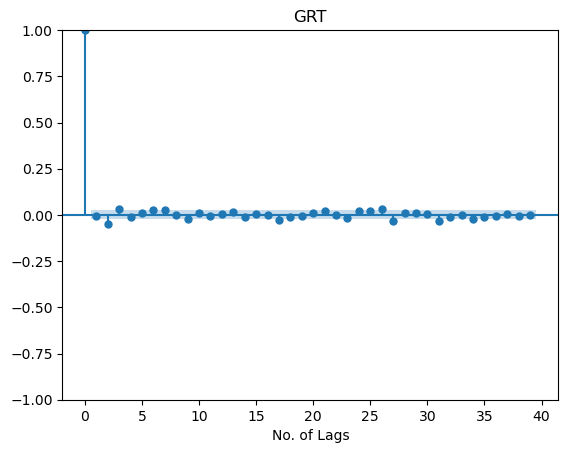

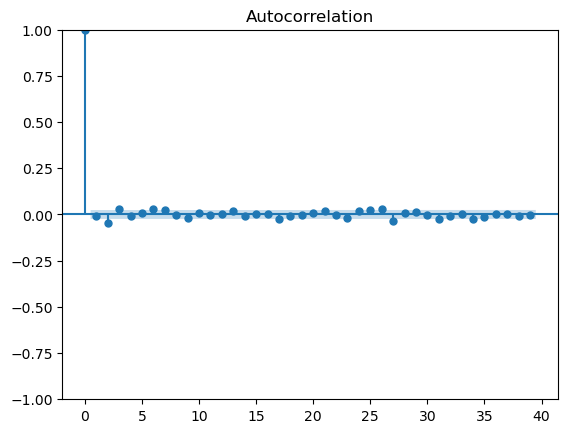

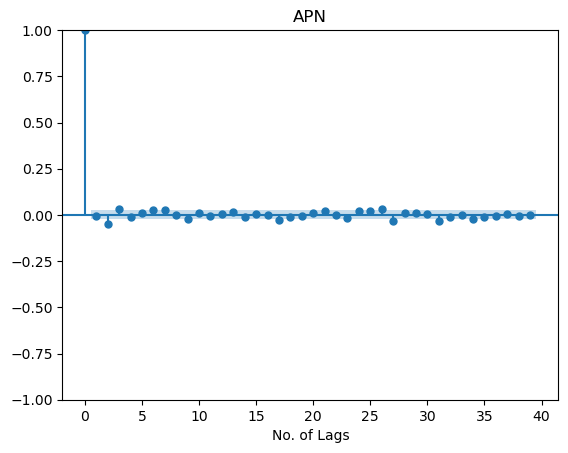

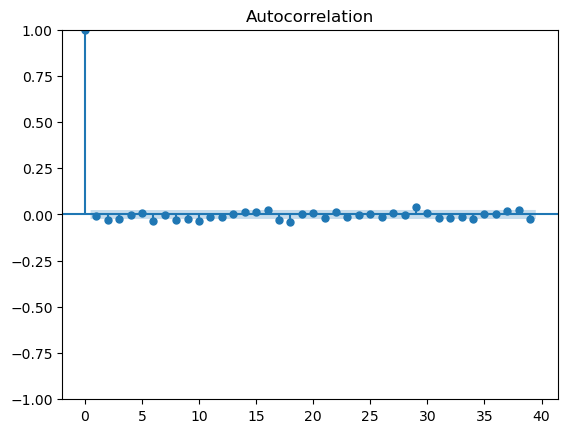

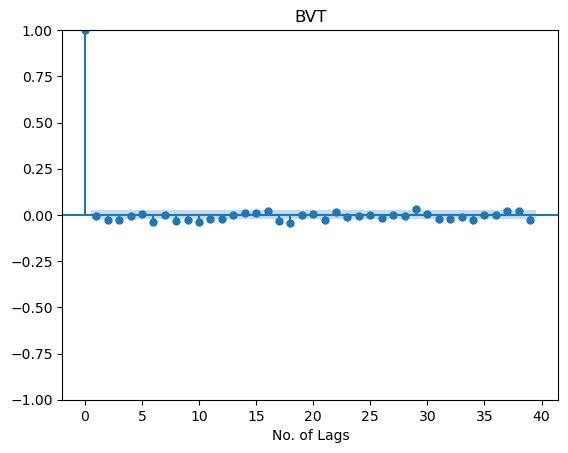

In [49]:
# Auto-Correlation Function (ACF) and Partial Auto-Correlation (PACF)
for col in dff.columns[1:]:
    plot_acf(dff[col])
    plot_pacf(dff[col])
    plt.title(col)
    plt.xlabel("No. of Lags")

#### Time Series Models

Now, that all series are stationary after first differentiating, we'll fit a few models to see best fit

C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    SBK   No. Observations:                 6618
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -45634.766
Date:                Mon, 26 May 2025   AIC                          91275.533
Time:                        15:20:30   BIC                          91295.925
Sample:                             0   HQIC                         91282.580
                               - 6618                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0807      0.003    -24.876      0.000      -0.087      -0.074
ma.L1         -0.9998      0.002   -551.991      0.000      -1.003      -0.996
sigma2      5.717e+04    271.676    210.437      0.0

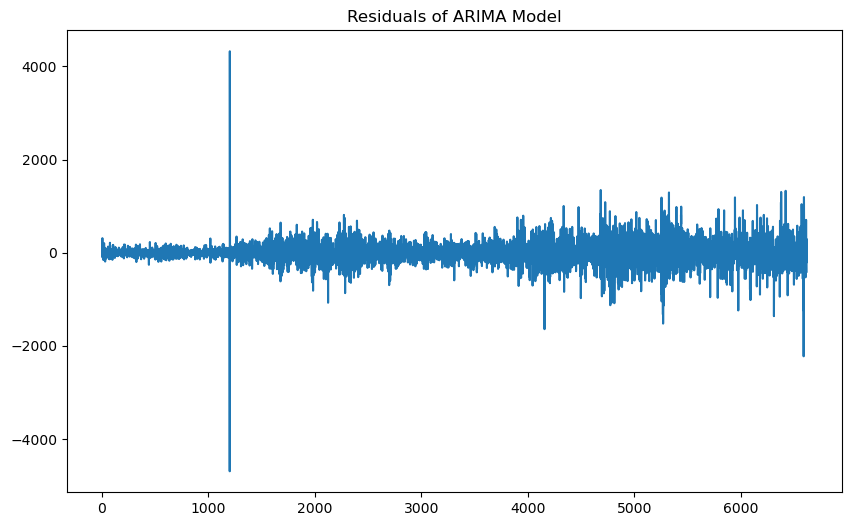

6618    35.329146
6619     0.606590
6620     3.408296
6621     3.182231
6622     3.200472
6623     3.199000
6624     3.199119
6625     3.199109
6626     3.199110
6627     3.199110
Name: predicted_mean, dtype: float64


C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [60]:
# Fit Models
model = ARIMA(dff.iloc[:, 2], order = (1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

forecast = model_fit.forecast(steps=10)
print(forecast)

In [63]:
#SARIMA
model = SARIMAX(dff.iloc[:, 2], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit()

print(model_fit.summary())

forecast = model_fit.forecast(steps=10)
print(forecast)

C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                SBK   No. Observations:                 6618
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood              -45595.403
Date:                            Mon, 26 May 2025   AIC                          91198.806
Time:                                    15:23:23   BIC                          91225.988
Sample:                                         0   HQIC                         91208.200
                                           - 6618                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0801      0.003    -24.608      0.000      -0.086      -0.074
ma.L1         -0.9999      0.010   

C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
